In [3]:
from pathlib import Path
from cyvcf2 import VCF
import pandas as pd

# Resolve project root (repo root)
PROJECT_ROOT = Path.cwd().resolve().parent

# Data directories
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw" / "clinvar"

# ClinVar VCF path
CLINVAR_VCF_GZ = RAW_DATA_DIR / "clinvar_20240416.vcf.gz"

# Sanity check
assert CLINVAR_VCF_GZ.exists(), f"ClinVar VCF not found at {CLINVAR_VCF_GZ}"

print("Using ClinVar VCF:", CLINVAR_VCF_GZ)


In [8]:
rows = []

# Open VCF file
vcf = VCF(CLINVAR_VCF_GZ)

# Loop through all variants
for var in vcf:
    ref = var.REF
    alts = var.ALT

    # Skip non-SNV reference alleles
    if ref is None or alts is None or len(ref) != 1:
        continue

    # Loop through alternate alleles
    for alt in alts:
        # Skip non-SNV alternate alleles
        if alt is None or len(alt) != 1:
            continue

        # Store relevant fields
        rows.append({
            "chrom": str(var.CHROM),
            "pos": int(var.POS),
            "ref": ref.upper(),
            "alt": alt.upper(),
            "clnsig": var.INFO.get("CLNSIG"),
            "review_status": var.INFO.get("CLNREVSTAT"),
            "molecular_consequence": var.INFO.get("MC"),
            "geneinfo": var.INFO.get("GENEINFO"),
            "disease_name": var.INFO.get("CLNDN"),
        })

# Convert to DataFrame
df = pd.DataFrame(rows)

print(df.shape)
df.head()


[W::vcf_parse] Contig '1' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '2' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '3' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '4' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '5' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '6' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '7' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '8' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '9' is not defined in the header. (Quick workaround: index the file with tabix.)
[W::vcf_parse] Contig '10' is not defined in the header. (Quick workaroun

(2493180, 9)


,chrom,pos,ref,alt,clnsig,review_status,molecular_consequence,geneinfo,disease_name
0,1,69134,A,G,Likely_benign,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
1,1,69581,C,G,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
2,1,69682,G,A,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
3,1,69769,T,C,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
4,1,69995,G,C,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases


In [9]:
# Add 'chr' prefix to chromosome names
df["chrom"] = "chr" + df["chrom"].astype(str)

# Ensure SNVs only (safety check)
df = df[
    (df["ref"].str.len() == 1) &
    (df["alt"].str.len() == 1)
].copy()

df.shape
df.head()

,chrom,pos,ref,alt,clnsig,review_status,molecular_consequence,geneinfo,disease_name
0,chr1,69134,A,G,Likely_benign,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
1,chr1,69581,C,G,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
2,chr1,69682,G,A,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
3,chr1,69769,T,C,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases
4,chr1,69995,G,C,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases


In [10]:
# Remove variants with no sequence alteration
df = df[
    ~df["molecular_consequence"].astype(str).str.contains(
        "no_sequence_alteration",
        case=False,
        na=False
    )
].copy()

df.shape


(2493060, 9)

In [11]:
# Count clinical significance labels
df["clnsig"].value_counts().head(20)


clnsig
Uncertain_significance                          1163912
Likely_benign                                    830619
Benign                                           175707
Conflicting_classifications_of_pathogenicity     115105
Pathogenic                                        75390
Likely_pathogenic                                 56710
Benign/Likely_benign                              44605
Pathogenic/Likely_pathogenic                      17794
not_provided                                       8116
drug_response                                      1675
other                                              1551
no_classification_for_the_single_variant            473
risk_factor                                         327
association                                         302
Uncertain_significance/Uncertain_risk_allele        119
Affects                                             114
Likely_risk_allele                                   83
Pathogenic|other                         

In [14]:
# Keep only "classic" ClinVar CLNSIG labels
classic_clnsig = {
    "Benign",
    "Likely_benign",
    "Uncertain_significance",
    "Likely_pathogenic",
    "Pathogenic",
    "Benign/Likely_benign",
    "Pathogenic/Likely_pathogenic",
}

df = df[df["clnsig"].isin(classic_clnsig)].copy()

df["clnsig"].value_counts()


clnsig
Uncertain_significance          1163912
Likely_benign                    830619
Benign                           175707
Pathogenic                        75390
Likely_pathogenic                 56710
Benign/Likely_benign              44605
Pathogenic/Likely_pathogenic      17794
Name: count, dtype: int64

In [15]:
# Count molecular consequence annotations
df["molecular_consequence"].value_counts().head(20)


molecular_consequence
SO:0001583|missense_variant                                                                            928379
SO:0001819|synonymous_variant                                                                          441618
SO:0001627|intron_variant                                                                              391361
SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant                                   122938
SO:0001583|missense_variant,SO:0001627|intron_variant                                                   74260
SO:0001619|non-coding_transcript_variant,SO:0001819|synonymous_variant                                  59837
SO:0001587|nonsense                                                                                     48818
SO:0001624|3_prime_UTR_variant                                                                          39968
SO:0001627|intron_variant,SO:0001819|synonymous_variant                                           

In [16]:
import pandas as pd

def normalize_clnsig(raw):
    # Coarse ClinVar groups: benign / pathogenic / vus / conflicting / other
    if raw is None or pd.isna(raw):
        return None

    s = str(raw).strip().lower()

    # Handle special/low-info labels
    if s in {"not_provided", "not provided"}:
        return "other"

    # Handle common groups (order matters)
    if "conflict" in s:
        return "conflicting"
    if "uncertain" in s:
        return "vus"
    if "pathogenic" in s:
        return "pathogenic"
    if "benign" in s:
        return "benign"

    return "other"


def parse_mc_terms(mc):
    # Extract consequence term(s) from MC like "SO:0001583|missense_variant,SO:...|intron_variant"
    if mc is None or pd.isna(mc):
        return []

    parts = [p.strip() for p in str(mc).split(",")]
    terms = [(p.split("|", 1)[1].strip() if "|" in p else p) for p in parts]
    return [t for t in terms if t]


def functional_class_snv(mc):
    # Assign SNV functional classes based on MC terms
    terms = parse_mc_terms(mc)
    if not terms:
        return "other"

    joined = " ".join(terms).lower()

    # Splice (priority)
    if any(x in joined for x in ["splice_donor_variant", "splice_acceptor_variant", "splice_region_variant"]):
        return "splice"

    # Nonsense / truncating
    if any(x in joined for x in ["stop_gained", "stop_lost", "start_lost"]):
        return "nonsense"

    # Coding SNVs
    if "missense_variant" in joined:
        return "missense"
    if "synonymous_variant" in joined:
        return "synonymous"

    # UTR / intronic
    if any(x in joined for x in ["5_prime_utr_variant", "3_prime_utr_variant"]):
        return "utr"
    if "intron_variant" in joined:
        return "intronic"

    # Non-coding transcript
    if "non_coding_transcript_variant" in joined:
        return "noncoding_transcript"

    # Upstream / downstream
    if "genic_upstream_transcript_variant" in joined:
        return "upstream"
    if "genic_downstream_transcript_variant" in joined:
        return "downstream"

    return "other"


# Add grouped labels
df["clinical_group"] = df["clnsig"].apply(normalize_clnsig)
df["functional_class"] = df["molecular_consequence"].apply(functional_class_snv)

# Quick summaries
df["functional_class"].value_counts().head(20)
df["clinical_group"].value_counts().head(20)

df.head()


,chrom,pos,ref,alt,clnsig,review_status,molecular_consequence,geneinfo,disease_name,clinical_group,functional_class
0,chr1,69134,A,G,Likely_benign,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases,benign,missense
1,chr1,69581,C,G,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases,vus,missense
2,chr1,69682,G,A,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases,vus,missense
3,chr1,69769,T,C,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases,vus,missense
4,chr1,69995,G,C,Uncertain_significance,"criteria_provided,_single_submitter",SO:0001583|missense_variant,OR4F5:79501,Inborn_genetic_diseases,vus,missense


In [18]:
df["functional_class"].value_counts()

functional_class
missense      1214360
synonymous     573289
intronic       399590
utr             71180
other           67413
splice          37303
nonsense          957
upstream          540
downstream        105
Name: count, dtype: int64

In [19]:
df["clinical_group"].value_counts()

clinical_group
vus           1163912
benign        1050931
pathogenic     149894
Name: count, dtype: int64

Clinical group counts:
clinical_group
vus           1163912
benign        1050931
pathogenic     149894
Name: count, dtype: int64


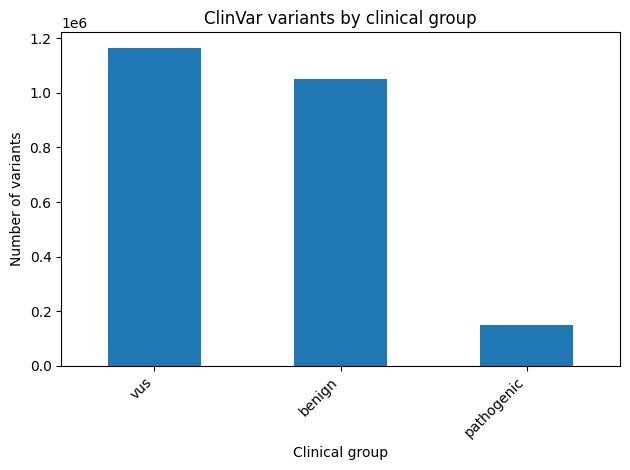

In [20]:
import matplotlib.pyplot as plt

clinical_counts = df["clinical_group"].value_counts()

print("Clinical group counts:")
print(clinical_counts)

plt.figure()
clinical_counts.plot(kind="bar")
plt.xlabel("Clinical group")
plt.ylabel("Number of variants")
plt.title("ClinVar variants by clinical group")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



Functional class counts:
functional_class
missense      1214360
synonymous     573289
intronic       399590
utr             71180
other           67413
splice          37303
nonsense          957
upstream          540
downstream        105
Name: count, dtype: int64


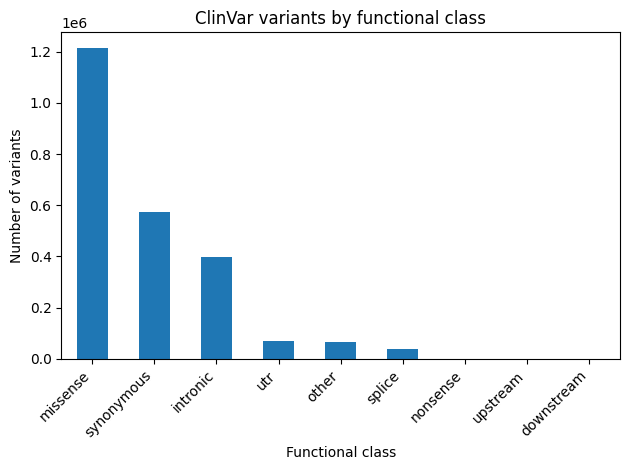

In [21]:
functional_counts = df["functional_class"].value_counts()

print("\nFunctional class counts:")
print(functional_counts)

plt.figure()
functional_counts.plot(kind="bar")
plt.xlabel("Functional class")
plt.ylabel("Number of variants")
plt.title("ClinVar variants by functional class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



Functional class × clinical group:
clinical_group    benign  pathogenic      vus
functional_class                             
downstream            61           1       43
intronic          351876        7055    40659
missense          108881       58653  1046826
nonsense              91         183      683
other               7051       48495    11867
splice               463       31691     5149
synonymous        553640         758    18891
upstream             391           8      141
utr                28477        3050    39653


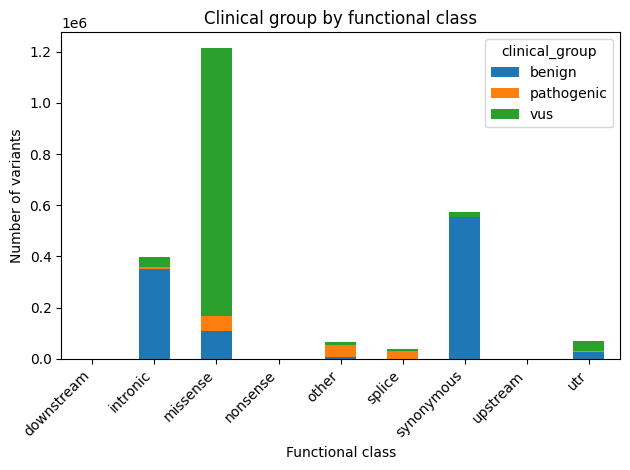

In [22]:
cross_tab = pd.crosstab(df["functional_class"], df["clinical_group"])

print("\nFunctional class × clinical group:")
print(cross_tab)

cross_tab.plot(kind="bar", stacked=True)
plt.xlabel("Functional class")
plt.ylabel("Number of variants")
plt.title("Clinical group by functional class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [25]:
df_balanced = (
    df
    .groupby(["clinical_group", "functional_class"], group_keys=False)
    .apply(lambda x: x.sample(
        n=min(
            x.shape[0],
            df[df["clinical_group"] == "pathogenic"]
                .query("functional_class == @x.name[1]")
                .shape[0]
        ),
        random_state=42
    ))
    .reset_index(drop=True)
)

df_balanced["clinical_group"].value_counts()

/var/folders/t7/xlq3thrd3bn646lmxy5vp3800000gn/T/ipykernel_13315/1950859595.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


clinical_group
pathogenic    149894
vus            86724
benign         77130
Name: count, dtype: int64

Balanced clinical group counts:
clinical_group
pathogenic    149894
vus            86724
benign         77130
Name: count, dtype: int64


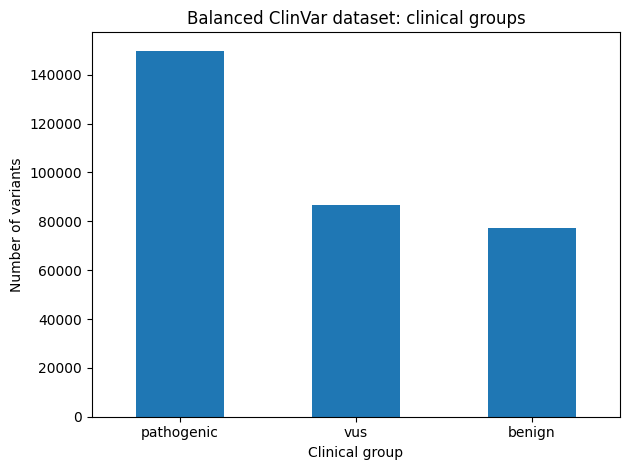

In [26]:
import matplotlib.pyplot as plt

counts = df_balanced["clinical_group"].value_counts()

print("Balanced clinical group counts:")
print(counts)

plt.figure()
counts.plot(kind="bar")
plt.xlabel("Clinical group")
plt.ylabel("Number of variants")
plt.title("Balanced ClinVar dataset: clinical groups")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Functional class counts:
functional_class
missense      175959
other          67413
splice         37303
intronic       21165
utr             9150
synonymous      2274
nonsense         457
upstream          24
downstream         3
Name: count, dtype: int64


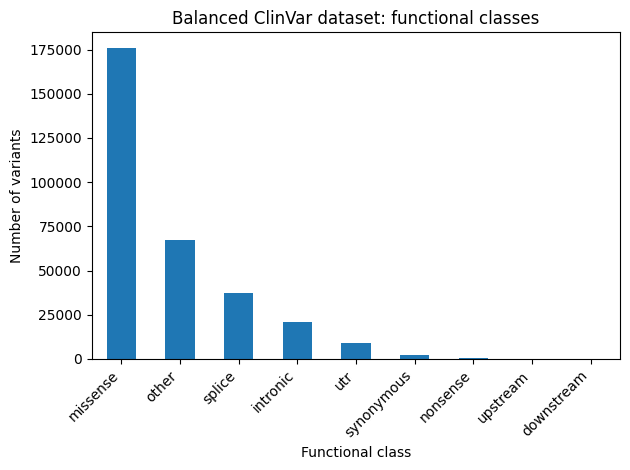

In [27]:
func_counts = df_balanced["functional_class"].value_counts()

print("\nFunctional class counts:")
print(func_counts)

plt.figure()
func_counts.plot(kind="bar")
plt.xlabel("Functional class")
plt.ylabel("Number of variants")
plt.title("Balanced ClinVar dataset: functional classes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Functional class × clinical group:
clinical_group    benign  pathogenic    vus
functional_class                           
downstream             1           1      1
intronic            7055        7055   7055
missense           58653       58653  58653
nonsense              91         183    183
other               7051       48495  11867
splice               463       31691   5149
synonymous           758         758    758
upstream               8           8      8
utr                 3050        3050   3050


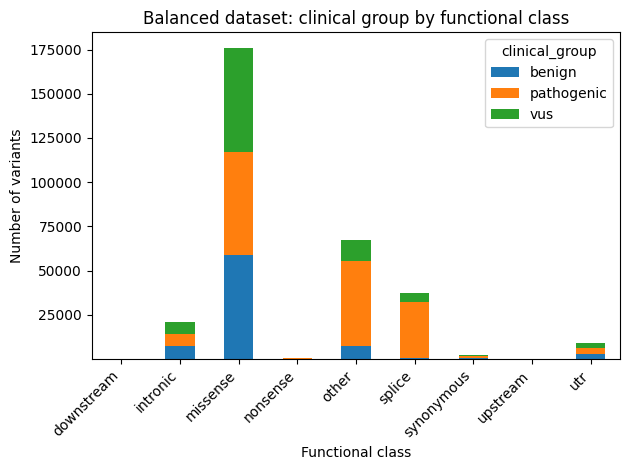

In [30]:
cross_tab = pd.crosstab(
    df_balanced["functional_class"],
    df_balanced["clinical_group"]
)

print("\nFunctional class × clinical group:")
print(cross_tab)

cross_tab.plot(kind="bar", stacked=True)
plt.xlabel("Functional class")
plt.ylabel("Number of variants")
plt.title("Balanced dataset: clinical group by functional class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [32]:
from pathlib import Path

# Resolve project root (repo root)
PROJECT_ROOT = Path.cwd().resolve().parent

# Processed data directory
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / "clinvar_clean"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Output path
OUTFILE = PROCESSED_DIR / "clinvar_balanced_benign_pathogenic_vus.csv"

# Save
df_balanced.to_csv(OUTFILE, index=False)

print(f"Saved df_balanced to {OUTFILE}")

Saved df_balanced to clinvar_balanced_benign_pathogenic_vus.csv
